# Step 0 - Read in required libraries and construct helper functions

### Import libraries and read from CSV

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import sklearn.model_selection as ms
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from math import sqrt
from statistics import mean 

%matplotlib inline

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

### Helper functions

In [2]:
# Given a list of indices (rows) to drop, this returns a copy of the original df without those rows
def remove_rows_from_df(df, list_of_rows_to_drop, printDetails = False):
    df_rows_removed = df.drop(df.index[list_of_rows_to_drop])
    if printDetails:
        print(len(set(list_of_rows_to_drop)),"observations (rows) dropped from dataframe")
        print("Dimensions of new dataframe:", df_rows_removed.shape)
    return df_rows_removed

# Example of usage
list_of_rows_to_remove = [57, 57, 72, 101]
df_with_rows_removed = remove_rows_from_df(df_train, list_of_rows_to_remove, printDetails = True)

3 observations (rows) dropped from dataframe
Dimensions of new dataframe: (1457, 81)


In [3]:
# Input: dataframe, column name, and threshold for determining if observation is outlier in column
# Ouput: a set whose elements are the indices (rows) of the outliers in this data frame
def indices_of_outliers(df, column_name, stdev_threshold, printDetails = False):
    mask_of_outliers = np.abs(df[column_name] - df[column_name].mean()) >= (stdev_threshold*df[column_name].std())
    set_of_indices_of_outliers = set(df.index[mask_of_outliers].tolist())
    if printDetails:
        print("There are",len(set_of_indices_of_outliers),"outliers in",column_name,"and their indices are:")
        print(set_of_indices_of_outliers)
    return set_of_indices_of_outliers

# "Vectorized" version of set_of_outliers and removes all of them from dataframe
# Non-mutatable, i.e. - original dataframe is not modified. Returns a new dataframe without outliers
def remove_rows_with_outliers(df, list_of_column_names, stdev_threshold, printDetails = False):
    set_of_indices_of_all_outliers = set()
    for column_name in list_of_column_names:
        set_of_indices_of_outliers = indices_of_outliers(df, column_name, stdev_threshold, printDetails)
        if printDetails:
            print("")
        set_of_indices_of_all_outliers = set_of_indices_of_all_outliers.union(set_of_indices_of_outliers)
    list_of_indices_to_drop = list(set_of_indices_of_all_outliers)
    if printDetails:
        print("Dropping outliers based on", stdev_threshold, "standard deviation criteria...")
    df_without_outliers = remove_rows_from_df(df, list_of_indices_to_drop, printDetails)
    return df_without_outliers

# Example of usage
list_of_column_names = ["LotFrontage", "OverallQual"]
df_without_outliers = remove_rows_with_outliers(df_train, list_of_column_names, stdev_threshold = 3, printDetails = True)

There are 12 outliers in LotFrontage and their indices are:
{197, 934, 807, 231, 1127, 1337, 909, 1298, 1107, 313, 1211, 1182}

There are 2 outliers in OverallQual and their indices are:
{533, 375}

Dropping outliers based on 3 standard deviation criteria...
14 observations (rows) dropped from dataframe
Dimensions of new dataframe: (1446, 81)


In [4]:
# For certain features, NA represents "None", i.e. - GarageType = NA -> there is no Garage for this house
# Pass in a list of features where you want the NA to be replaced with type "None"
def replace_NA_with_None(df, series_names, printDetails = False):
    
    for series_name in series_names:
        df.loc[df[series_name].isnull(), series_name] = 'None'
        if printDetails:
            print('*'*20)
            print(df[series_name].value_counts(sort = True))
            print('*'*20)
            print('')
    
    return df

In [5]:
# For features where we need to impute NA with mode or median
def replace_NA_with_imputation(df, printDetails = False):
    # For houses without LotFrontage, use the median from that neighborhood
    df['LotFrontage'] = df.groupby(['Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    df['Electrical'] = df['Electrical'].fillna('SBrkr')
    df['MasVnrType'] = df.groupby(['Neighborhood'])['MasVnrType'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # Where there is no MasVnrType, assign the missing values of area to be zero
    mask_1 = (df["MasVnrType"] == "None") & (df["MasVnrArea"].isna())
    df.loc[mask_1, "MasVnrArea"]  = 0.0
    
    # There is 1 house with a "stone" type MasVnrType, with no area, so we impute using median area for stone types
    df['MasVnrArea'] = df.groupby(['MasVnrType'])['MasVnrArea'].transform(lambda x: x.fillna(x.median()))
    
    # There is one house in test set that containing missing value in GarageArea, seems like it does not have a Garage
    df['GarageArea']= df['GarageArea'].fillna(0)
    df['GarageCars']= df['GarageCars'].fillna(0)
    
    # Only one house has missing value in BsmtSF due to no basement, should fill NA with 0
    df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0)
    df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(0)
    df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(0)
    df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(0)
    
    # There are 2 houses that have missing values in basement bathroom due to no basement 
    df['BsmtFullBath'] = df['BsmtFullBath'].fillna(0)
    df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(0)
    df['Exterior1st'] = df.groupby(['RoofMatl'])['Exterior1st'].transform(lambda x: x.fillna(x.mode()[0])) 
    df['Exterior2nd'] = df.groupby(['RoofMatl'])['Exterior2nd'].transform(lambda x: x.fillna(x.mode()[0])) 
    df['KitchenQual'] = df.groupby(['OverallCond'])['KitchenQual'].transform(lambda x: x.fillna(x.mode()[0])) # group by Overall Condition
    
    # 2 houses have missing values in Functional. Both are in poor quality condition and sold as abnormal type. Should not consider it as Functional_typ
    df['Functional'] = df['Functional'].fillna('Mod')
    
    # 4 houses having missing values in MSZoning
    df['MSZoning'] = df.groupby(['Neighborhood'])['MSZoning'].transform(lambda x:x.fillna(x.mode()[0]))
    df['Utilities'] = df['Utilities'].fillna('AllPub')
    df['SaleType'] = df.groupby(['SaleCondition'])['SaleType'].transform(lambda x: x.fillna(x.mode()[0]))
    
    if printDetails:
        print("Imputed NA's in:")
        print("LotFrontage, Electrical, MasVnrType, GarageArea, GarageCars, TotalBsmtSF, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, BsmtFullBath, BsmtHalfBath, Exterior1st, Exterior2nd, KitchenQual, Functional, MSZoning, Utilities, SaleType")
    
    return df

In [6]:
# Create custom features function
# The weights were chosen based on which had the highest correlation
def create_custom_features(df, printDetails):
    
    # Create Custom Feature: Adjusted Total Basement Area
    df['AdjTotalBsmtSF'] = df['BsmtFinSF1']+df['BsmtFinSF2']+0.9*df['BsmtUnfSF']
    
    # Create Custom Feature: Adjusted Total Bathroom 
    df['AdjTotalBath'] = df['FullBath']+df['BsmtFullBath']+0.6*(df['HalfBath']+df['BsmtHalfBath'])
    
    # Create Custom Feature: HouseAge
    df['HouseAge'] = df['YrSold']-(0.6*df['YearRemodAdd']+0.4*df['YearBuilt'])
    
    # Custom Feature: AdjOutdoorSF
    df['AdjOutdoorSF'] = df['3SsnPorch']+df['EnclosedPorch']+df['OpenPorchSF']+df['ScreenPorch']+df['WoodDeckSF']
    
    # Transform SalePrice to LogSalePrice 
    df['LogSalePrice'] = np.log(df['SalePrice'])
    
    if printDetails:
        print("The weights were chosen based on correlation with SalePrice")
        print("df['AdjTotalBsmtSF'] = df['BsmtFinSF1']+df['BsmtFinSF2']+0.9*df['BsmtUnfSF']")
        print("df['AdjTotalBath'] = df['FullBath']+df['BsmtFullBath']+0.6*(df['HalfBath']+df['BsmtHalfBath'])")
        print("df['HouseAge'] = df['YrSold']-(0.6*df['YearRemodAdd']+0.4*df['YearBuilt'])")
        print("df['AdjOutdoorSF'] = df['3SsnPorch']+df['EnclosedPorch']+df['OpenPorchSF']+df['ScreenPorch']+df['WoodDeckSF']")
        print("df['LogSalePrice'] = np.log(df['SalePrice'])")
    
    return df

In [7]:
def dummify_categorical(df, columns):
    for col in columns:
        # value_counts (sort by frequency)
        grouped = df.groupby(col)[[col]].agg('count').rename(columns={col:'count'}).sort_values(by = "count", ascending = False)
        # dummify all categories
        df = pd.get_dummies(df, columns=[col], prefix=col, prefix_sep='_') 
        # categories with frequency less than 65
        columns_to_drop = list(grouped.loc[grouped['count']<145].index)
        columns_to_drop = [col + "_" + i for i in columns_to_drop]
        # drop dummified columns
        if len(columns_to_drop) > 0:
            df = df.drop(columns = columns_to_drop,axis = 1)
        else:
            # when all the categories have frequency higher than 70
            df = df.drop(col + "_" + grouped.index[0], axis=1)
    return df

In [8]:
def impute_ordinal(df, list_of_dic_to_replace):
    for dic in list_of_dic_to_replace:
        df = df.replace(dic)
    return df

# Step 1 - Preview the data, and combine it

### Check the dimensions of the dataframes

In [9]:
# Check dimensions of the train and test set
print("Training data set dimensions: ", df_train.shape)
print("Testing data set dimensions: ", df_test.shape)

Training data set dimensions:  (1460, 81)
Testing data set dimensions:  (1459, 80)


### Check the columns of the dataframes

In [10]:
# Check columns in both data sets
print("Train df:")
print(df_train.columns)
print("")
print("Test df: ")
print(df_test.columns)

Train df:
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', '

In [11]:
# Verify that the only difference in the columns between train vs. test set is the response SalePrice
column_difference = set(df_train.columns).difference(set(df_test.columns))
print("Verify that the only difference in train vs. test columns is:", column_difference)

Verify that the only difference in train vs. test columns is: {'SalePrice'}


### Combine the train & test dataframes so that we can engineer features and process NA's just once instead of twice

In [12]:
df_combined = df_train.append(df_test,sort = False)

In [13]:
df_combined.shape

(2919, 81)

# Step 2 - Handle missing values

In [14]:
# Check the number of missing values in the original dataframe
print("Feature\t\tMissing value count")
print(df_combined.isnull().sum()[df_combined.isnull().sum()>0])

Feature		Missing value count
MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
SalePrice       1459
dtype: int64


In [15]:
# For these features, we replace the NA with "None", i.e. - if Garage is NA, the house doesn't have a garage
series_names = ['BsmtExposure','BsmtQual','FireplaceQu','GarageQual','GarageType','GarageYrBlt','GarageFinish',\
                'GarageCond','PoolQC','Fence','MiscFeature','Alley','BsmtCond','BsmtFinType1','BsmtFinType2']

df_combined = replace_NA_with_None(df_combined, series_names, printDetails = False)

In [16]:
# Check the number of missing values in the original dataframe after processing
print("Feature\t\tMissing value count")
print(df_combined.isnull().sum()[df_combined.isnull().sum()>0])

Feature		Missing value count
MSZoning           4
LotFrontage      486
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
GarageCars         1
GarageArea         1
SaleType           1
SalePrice       1459
dtype: int64


In [17]:
# Replace NAs in other features with mode and median
df_combined = replace_NA_with_imputation(df_combined, printDetails = True)

Imputed NA's in:
LotFrontage, Electrical, MasVnrType, GarageArea, GarageCars, TotalBsmtSF, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, BsmtFullBath, BsmtHalfBath, Exterior1st, Exterior2nd, KitchenQual, Functional, MSZoning, Utilities, SaleType


In [18]:
# Check that we have cleared out all of the NA's in the predictors (features)
print("There are no more NA's in the features now")
print("The only missing values are in SalePrice, and only because the test dataframe has no price")
df_combined.isnull().sum()[df_combined.isnull().sum()>0]

There are no more NA's in the features now
The only missing values are in SalePrice, and only because the test dataframe has no price


SalePrice    1459
dtype: int64

# Step 3 - Create customized features

In [19]:
df_combined = create_custom_features(df_combined, printDetails = True)

The weights were chosen based on correlation with SalePrice
df['AdjTotalBsmtSF'] = df['BsmtFinSF1']+df['BsmtFinSF2']+0.9*df['BsmtUnfSF']
df['AdjTotalBath'] = df['FullBath']+df['BsmtFullBath']+0.6*(df['HalfBath']+df['BsmtHalfBath'])
df['HouseAge'] = df['YrSold']-(0.6*df['YearRemodAdd']+0.4*df['YearBuilt'])
df['AdjOutdoorSF'] = df['3SsnPorch']+df['EnclosedPorch']+df['OpenPorchSF']+df['ScreenPorch']+df['WoodDeckSF']
df['LogSalePrice'] = np.log(df['SalePrice'])


In [20]:
df_combined.shape

(2919, 86)

# Step 4 - Build Linear Models

### Dummify categorical

In [21]:
list_of_categorical = list(df_combined.select_dtypes(include=[object]).drop(["BsmtExposure", "BsmtQual", "ExterQual", "FireplaceQu",
                                                  "KitchenQual", "GarageQual","HeatingQC", "BsmtCond",
                                                  "ExterCond", "Fence","GarageCond", "PoolQC", "GarageYrBlt"
                                                 ],axis=1).columns)
df_dummified = dummify_categorical(df_combined, list_of_categorical)

### Convert ordinal categorical variables to values

In [22]:
list_of_dic_to_replace = [
    {"BsmtExposure": {"Gd": 5, "Av": 4, "Mn": 3, "No": 2, "None": 0}},
    {"BsmtQual": {"Ex": 7, "Gd": 4, "TA": 2, "Fa": 1, "Po": 0, "None": 0}},
    {"ExterQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 1}}, # "Po": 0
    {"FireplaceQu": {"Ex": 5, "Gd": 3, "TA": 2.5, "Fa": 1.5, "Po":0, "None": 0.5}},
    {"KitchenQual": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1}},    #"Po": 0
    {"GarageQual": {"Ex": 5, "Gd": 5, "TA": 4.5, "Fa": 2.5, "Po": 1, "None": 1}},
    {"HeatingQC": {"Ex": 3, "Gd": 2, "TA": 1.5, "Fa": 1, "Po": 0}},
    {"BsmtCond": {"Gd":7, "TA":6, "Fa": 4,"None": 3, "Po": 0}},
    {"ExterCond": {"Ex":7, "TA":6, "Gd": 5,"Fa": 2, "Po": 0}},
    {"GarageCond": {"Ex":3, "TA":6, "Gd": 6,"Fa": 1, "Po": 1, "None":0}}
]

df_ordinal_dummified = impute_ordinal(df_dummified,list_of_dic_to_replace)

### Continuous features

In [23]:
list_of_continuous_columns = ['AdjTotalBsmtSF', 'GarageArea', 'GrLivArea', 'HouseAge', 'LotArea',\
                              'AdjTotalBath', 'AdjOutdoorSF', 'OverallQual',\
                              'BedroomAbvGr', 'Fireplaces', 'LotFrontage', 'MasVnrArea', "BsmtUnfSF",
                              "LowQualFinSF", "MiscVal"]

### Combine together continuous, dummified categorical, and ordinal categorical

In [24]:
list_of_dummified_categorical = ['MSZoning_RL','MSZoning_RM','Street_Pave','Alley_None','LotShape_IR1','LotShape_Reg',
 'LandContour_Lvl', 'Utilities_AllPub', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_Inside', 'LandSlope_Gtl',
 'Neighborhood_CollgCr','Neighborhood_Edwards','Neighborhood_Gilbert','Neighborhood_NAmes','Neighborhood_NridgHt',
 'Neighborhood_OldTown','Neighborhood_Sawyer', 'Neighborhood_Somerst', 'Condition1_Feedr','Condition1_Norm',
 'Condition2_Norm','BldgType_1Fam','BldgType_TwnhsE','HouseStyle_1.5Fin','HouseStyle_1Story','HouseStyle_2Story',
 'RoofStyle_Gable','RoofStyle_Hip','RoofMatl_CompShg','Exterior1st_HdBoard','Exterior1st_MetalSd','Exterior1st_Plywood',
 'Exterior1st_VinylSd','Exterior1st_Wd Sdng','Exterior2nd_HdBoard', 'Exterior2nd_MetalSd', 'Exterior2nd_Plywood',
 'Exterior2nd_VinylSd','Exterior2nd_Wd Sdng','MasVnrType_BrkFace','MasVnrType_None','MasVnrType_Stone',
 'Foundation_BrkTil','Foundation_CBlock','Foundation_PConc','BsmtFinType1_ALQ','BsmtFinType1_BLQ','BsmtFinType1_GLQ',
 'BsmtFinType1_LwQ','BsmtFinType1_Rec','BsmtFinType1_Unf','BsmtFinType2_Unf','Heating_GasA','CentralAir_N',
 'Electrical_FuseA','Electrical_SBrkr','Functional_Typ','GarageType_Attchd','GarageType_BuiltIn','GarageType_Detchd',
 'GarageType_None','GarageFinish_Fin','GarageFinish_None','GarageFinish_RFn','PavedDrive_N','PavedDrive_Y',
 'MiscFeature_None','SaleType_New','SaleType_WD','SaleCondition_Abnorml','SaleCondition_Normal',
 'SaleCondition_Partial']

In [25]:
list_of_ordinal_categorical = ['BsmtExposure', 'BsmtQual', 'ExterQual', 'FireplaceQu', 'GarageQual',\
'HeatingQC', 'KitchenQual', "BsmtCond", "ExterCond", "GarageCond"] 

In [26]:
list_of_predictors = list_of_continuous_columns + list_of_dummified_categorical + list_of_ordinal_categorical 

In [27]:
len(list_of_predictors)

99

### Split Train and Test Data

In [28]:
df_train = df_ordinal_dummified.iloc[:1460,]
df_test = df_ordinal_dummified.iloc[1460:,]

### Remove outliers for Train dataset using standard deviation

In [29]:
df_without_outliers = remove_rows_with_outliers(df_train, list_of_continuous_columns, stdev_threshold = 5)
# around 100 rows removed

### Checking Multicollinearity

In [30]:
# Method: Using VIF to check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
VIF = add_constant(df_without_outliers.loc[:,list_of_continuous_columns])
pd.Series([variance_inflation_factor(VIF.values, i) 
               for i in range(VIF.shape[1])], 
              index=VIF.columns)

C:\Users\zhang\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const             77.344146
AdjTotalBsmtSF     1.927784
GarageArea         1.855823
GrLivArea          3.591806
HouseAge           2.297718
LotArea            1.479966
AdjTotalBath       2.822233
AdjOutdoorSF       1.251750
OverallQual        2.947152
BedroomAbvGr       1.738915
Fireplaces         1.434320
LotFrontage        1.425895
MasVnrArea         1.318286
BsmtUnfSF          1.680152
LowQualFinSF       1.023394
MiscVal            1.012163
dtype: float64

### Feature Selection using Lasso

In [31]:
X = df_without_outliers[list_of_predictors]
Y = df_without_outliers['LogSalePrice'].values

In [32]:
lasso_FS = Lasso(normalize=True, max_iter = 10000)
alpha_FS = np.logspace(-9, -2, 100)

alpha_coefs = []
for alpha in alpha_FS:
    lasso_FS.set_params(alpha=alpha)
    lasso_FS.fit(X, Y)
    alpha_coefs.append(lasso_FS.coef_)

# the order of predictors to become zero coefficient
coefs_df = pd.DataFrame(alpha_coefs, index=alpha_FS, columns = list_of_predictors)

Text(0, 0.5, 'slope values')

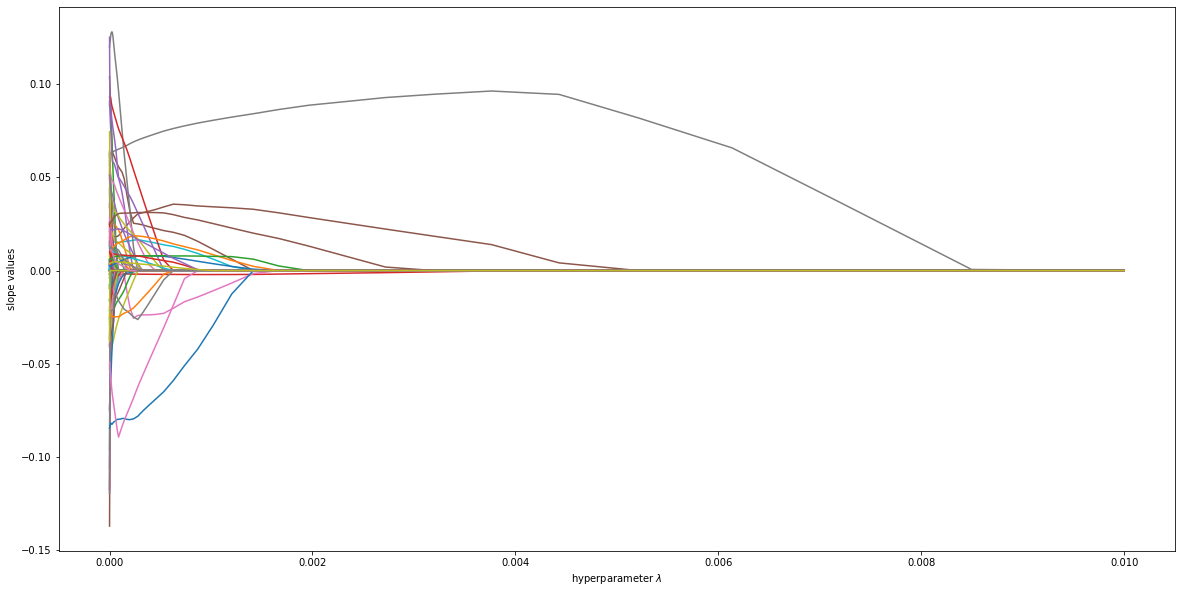

In [33]:
# feature selection graph
plt.figure(figsize=(20,10))
for name in coefs_df.columns:
    plt.plot(coefs_df.index, coefs_df[name], label=name)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')
# plt.legend(loc=1)

In [34]:
### find the alpha where coefficient becomes zero ###
alpha_zero = {}
for col in coefs_df.columns:
    for alpha in coefs_df.index:
        if coefs_df.loc[alpha, col] == 0:
            alpha_zero[col] = alpha
            break
alpha_zero = sorted(alpha_zero.items(), key=lambda x: x[1], reverse=True)

In [35]:
# the top features selected by Lasso
top_features = [item[0] for item in alpha_zero[:60]]

### Build Lasso Model

In [36]:
# using lasso selected features only
X_after_FS = X[top_features].values

# split the training data into 80% and 20%
X_train, X_test, y_train, y_test = ms.train_test_split(X_after_FS, Y, train_size=0.8, test_size=0.2, random_state=42)

In [37]:
# Cross Validation to find the best alpha

alphas_lasso = np.logspace(-9, -3.5, 100)
lasso = Lasso(normalize=True)

dic = {}
for alpha in alphas_lasso:
    lasso.set_params(alpha=alpha)
    rmse = np.sqrt(-ms.cross_val_score(lasso, X_train, y_train, 
                      scoring="neg_mean_squared_error",cv = 5))
    dic[alpha] = mean(rmse)

# rmse for different alpha
alpha_rmse = pd.DataFrame.from_dict(dic, orient='index', columns = ['RMSE']).reset_index()

Text(0, 0.5, 'RMSE')

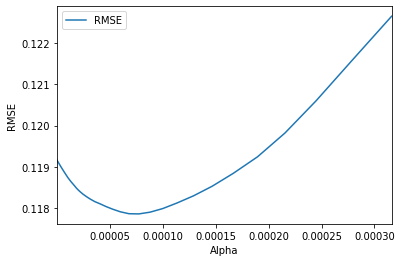

In [38]:
alpha_rmse.plot(x = "index", y = "RMSE")
plt.xlabel("Alpha")
plt.ylabel("RMSE")

In [39]:
alpha_optimal = alpha_rmse.sort_values(by='RMSE').iloc[0,0]

### Which houses (observations) are wildy mispredicted by our Lasso?  Show outliers

In [40]:
# Use previous optimal alpha to fit train 80% data set
lasso_2 = Lasso(normalize = True, alpha = alpha_optimal)
lasso_2.fit(X_train,y_train)
Y_predicted = lasso_2.predict(X_train)
residuals = y_train - Y_predicted

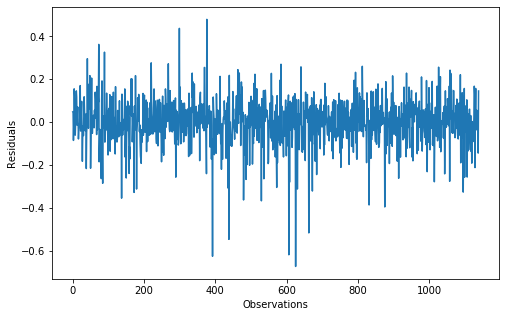

In [41]:
plt.figure(figsize=(8,5))
plt.ylabel("Residuals")
plt.xlabel("Observations")
plt.plot(residuals)

In [42]:
# indices of outliers
import itertools
indices_of_residual_outliers_under = list(itertools.chain(*np.argwhere(residuals>0.5).tolist()))
indices_of_residual_outliers_over = list(itertools.chain(*np.argwhere(residuals<-0.5).tolist()))

In [43]:
# indices of outliers
outliers_indices = indices_of_residual_outliers_under + indices_of_residual_outliers_over
outliers_indices

[392, 438, 606, 625, 662]

### Remove outliers and do cross validation again

In [44]:
X_train_no_outliers = pd.DataFrame(X_train).drop(outliers_indices)
y_train_no_outliers = pd.DataFrame(y_train).drop(outliers_indices).values.flatten() # convert it back to 1D array

In [45]:
# cross validation to find the best alpha
alphas_lasso_2 = np.logspace(-9, -4, 100)
lasso_2 = Lasso(normalize=True)

dic_2 = {}
for alpha in alphas_lasso_2:
    lasso_2.set_params(alpha=alpha)
    rmse_2 = np.sqrt(-ms.cross_val_score(lasso_2, X_train_no_outliers, y_train_no_outliers, 
                      scoring="neg_mean_squared_error",cv = 5))
    dic_2[alpha] = mean(rmse_2)

# rmse for different alpha
alpha_rmse_2 = pd.DataFrame.from_dict(dic_2, orient='index', columns = ['RMSE']).reset_index()

Text(0, 0.5, 'RMSE')

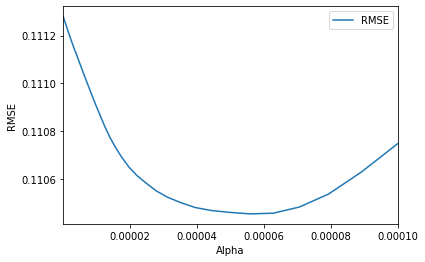

In [46]:
alpha_rmse_2.plot(x = "index", y = "RMSE")
plt.xlabel("Alpha")
plt.ylabel("RMSE")

In [47]:
alpha_optimal_2 = alpha_rmse_2.sort_values(by='RMSE').iloc[0,0]

### Use the optimal alpha to fit 80% of Train data

In [48]:
# Use this alpha_optimal_2 to fit 80% of Train model 

from sklearn.metrics import mean_squared_error
from math import sqrt

lasso_3 = Lasso(normalize=True,alpha = alpha_optimal_2)
lasso_3.fit(X_train_no_outliers,y_train_no_outliers)
#print(lasso_3.coef_)
y_train_predicted = lasso_3.predict(X_train_no_outliers)
RMSE_train = sqrt(mean_squared_error(y_train_no_outliers,y_train_predicted))


y_test_predicted = lasso_3.predict(X_test)
RMSE_test = sqrt(mean_squared_error(y_test,y_test_predicted))

print('RMSE for train data is: %.8f' % RMSE_train, 'using optimal alpha of %f' % alpha_optimal_2, '.')
print('RMSE for test data is: %.8f' % RMSE_test,'using optimal alpha of %f' % alpha_optimal_2, '.')


RMSE for train data is: 0.10264835 using optimal alpha of 0.000056 .
RMSE for test data is: 0.13822775 using optimal alpha of 0.000056 .


### Prediction of Test Data

In [49]:
df_test_predictors = df_test[top_features]

In [50]:
Predicted_LogPrice = lasso_3.predict(df_test_predictors)
Predicted_Price = np.exp(Predicted_LogPrice)
Final_Price_Lasso = pd.DataFrame(np.concatenate([df_test[['Id']],pd.DataFrame(Predicted_Price)],axis=1))
Final_Price_Lasso.columns= ['Id','SalePrice']
Final_Price_Lasso['Id'] = Final_Price_Lasso['Id'].astype('int32')

In [51]:
Final_Price_Lasso.to_csv("test_price_lasso.csv",index = False)

# Bayesian Ridge Regression

In [52]:
# Bayesian Ridge regression.  Tuning 4 parameters using 5-fold cross validation
# If you care about the details, here is the documentation
#    https://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression
#    https://en.wikipedia.org/wiki/Bayesian_linear_regression

# Using our original 80 variables

print("Dimensions of X:", X.shape)
print("Dimensions of Y:", Y.shape)
print("Dimensions of df_test[list_of_predictors]:", df_test[list_of_predictors].shape)

"""
# Error of 0.13239 on Kaggle
alpha_1_vector = np.logspace(-10, -4, 5).tolist()
alpha_2_vector = np.logspace(-8, -2, 5).tolist()
lambda_1_vector = np.logspace(-8, -2, 5).tolist()
lambda_2_vector = np.logspace(-8, -2, 5).tolist()
"""

# Error of 0.13237 on Kaggle
# Result of this grid Search is {'alpha_1': 1e-11, 'alpha_2': 1.0, 'lambda_1': 100.0, 'lambda_2': 0.1}
alpha_1_vector = np.logspace(-14, -10, 5).tolist()
alpha_2_vector = np.logspace(-2, 2, 5).tolist()
lambda_1_vector = np.logspace(0, 4, 5).tolist()
lambda_2_vector = np.logspace(-4, 0, 5).tolist()

bayesian_ridge_model = BayesianRidge(normalize = True)
bayesian_ridge_parameters = [{'alpha_1': alpha_1_vector, 'alpha_2': alpha_2_vector, 'lambda_1': lambda_1_vector, 'lambda_2': lambda_2_vector}]
bayesian_ridge_model_gridSearch = GridSearchCV(bayesian_ridge_model, bayesian_ridge_parameters, cv = 5, scoring = "neg_mean_squared_error")
bayesian_ridge_model_gridSearch.fit(X, Y)
print("Best parameters after 4D grid search:",bayesian_ridge_model_gridSearch.best_params_)

Predicted_LogPrice_BayesianRidge_gridSearch = bayesian_ridge_model_gridSearch.predict(df_test[list_of_predictors])
Predicted_Price_BayesianRidge_gridSearch = np.exp(Predicted_LogPrice_BayesianRidge_gridSearch)
Final_Price_BayesianRidge_gridSearch = pd.DataFrame(np.concatenate([df_test[['Id']],pd.DataFrame(Predicted_Price_BayesianRidge_gridSearch)],axis=1))
Final_Price_BayesianRidge_gridSearch.columns= ['Id','SalePrice']
Final_Price_BayesianRidge_gridSearch['Id'] = Final_Price_BayesianRidge_gridSearch['Id'].astype('int32')
Final_Price_BayesianRidge_gridSearch.to_csv("test_price_bayesian_ridge_gridSearch.csv",index = False)

Dimensions of X: (1424, 99)
Dimensions of Y: (1424,)
Dimensions of df_test[list_of_predictors]: (1459, 99)
Best parameters after 4D grid search: {'alpha_1': 1e-11, 'alpha_2': 1.0, 'lambda_1': 10.0, 'lambda_2': 1.0}


# Ridge Model

In [53]:
ridge = Ridge()
ridge.set_params(normalize = True, alpha = 0.0001)
ridge.fit(X_train,y_train)
print("R^2 for ridge model is: %.3f" % ridge.score(X_train,y_train))
y_train_predicted = ridge.predict(X_train)
y_test_predicted = ridge.predict(X_test)
print("RMSE_train for ridge mode is: %.3f" % sqrt(mean_squared_error(y_train,y_train_predicted)))
print("RMSE_test for ridge mode is: %.3f" % sqrt(mean_squared_error(y_test,y_test_predicted)))

R^2 for ridge model is: 0.923
RMSE_train for ridge mode is: 0.109
RMSE_test for ridge mode is: 0.137


In [54]:
# cross validation to find the best alpha
alphas_ridge = np.logspace(-5, -1, 100)
ridge = Ridge(normalize=True)

dic_ridge = {}
for alpha in alphas_ridge:
    ridge.set_params(alpha=alpha)
    rmse_ridge = np.sqrt(-ms.cross_val_score(ridge, X_train, y_train, 
                      scoring="neg_mean_squared_error",cv = 5))
    dic_ridge[alpha] = mean(rmse_ridge)

# rmse for different alpha
alpha_rmse_ridge = pd.DataFrame.from_dict(dic_ridge, orient='index', columns = ['RMSE']).reset_index()

Text(0, 0.5, 'RMSE')

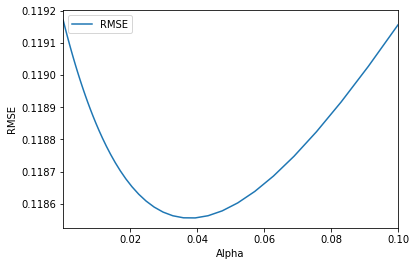

In [55]:
alpha_rmse_ridge.plot(x = "index", y = "RMSE")
plt.xlabel("Alpha")
plt.ylabel("RMSE")

In [56]:
alpha_optimal_ridge = alpha_rmse_ridge.sort_values(by='RMSE').iloc[0,0]
alpha_optimal_ridge

0.0394420605943766

In [57]:
# Use previous optimal alpha to fit train 80% data set
ridge_2 = Ridge(normalize = True, alpha = alpha_optimal_ridge)
ridge_2.fit(X_train,y_train)
Y_predicted_train = ridge_2.predict(X_train)
residuals = y_train - Y_predicted_train

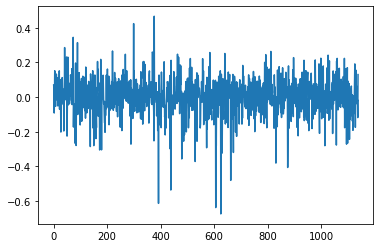

In [58]:
plt.plot(residuals)

In [59]:
import itertools
indices_of_residual_outliers_under = list(itertools.chain(*np.argwhere(residuals>0.5).tolist()))
indices_of_residual_outliers_over = list(itertools.chain(*np.argwhere(residuals<-0.5).tolist()))

In [60]:
# indices of outliers
outliers_indices = indices_of_residual_outliers_under + indices_of_residual_outliers_over
outliers_indices

[392, 438, 606, 625]

In [61]:
X_train_no_outliers = pd.DataFrame(X_train).drop(outliers_indices)
y_train_no_outliers = pd.DataFrame(y_train).drop(outliers_indices).values.flatten() # convert it back to 1D array

In [62]:
# # cross validation to find the best alpha
alphas_ridge_3 = np.logspace(-4, -1, 100)
ridge_3 = Ridge(normalize=True)

dic_ridge_3 = {}
for alpha in alphas_ridge_3:
    ridge_3.set_params(alpha=alpha)
    rmse_ridge_3 = np.sqrt(-ms.cross_val_score(ridge_3, X_train_no_outliers, y_train_no_outliers, 
                      scoring="neg_mean_squared_error",cv = 5))
    dic_ridge_3[alpha] = mean(rmse_ridge_3)

# rmse for different alpha
alpha_rmse_ridge_3 = pd.DataFrame.from_dict(dic_ridge_3, orient='index', columns = ['RMSE']).reset_index()

Text(0, 0.5, 'RMSE')

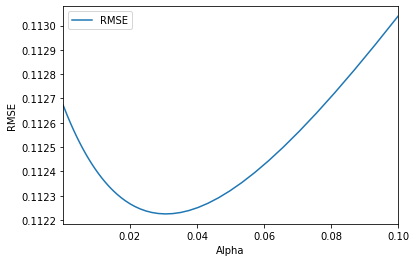

In [63]:
alpha_rmse_ridge_3.plot(x = "index", y = "RMSE")
plt.xlabel("Alpha")
plt.ylabel("RMSE")

In [64]:
alpha_optimal_ridge_3 = alpha_rmse_ridge_3.sort_values(by='RMSE').iloc[0,0]

In [65]:
alpha_optimal_ridge_3

0.030538555088334154

In [66]:
# # Use this alpha_optimal_ridge_3 to fit 80% of Train model 

from sklearn.metrics import mean_squared_error
from math import sqrt

ridge_4 = Ridge(normalize=True,alpha = alpha_optimal_ridge_3)
ridge_4.fit(X_train_no_outliers,y_train_no_outliers)
y_train_predicted = ridge_4.predict(X_train_no_outliers)
RMSE_train = sqrt(mean_squared_error(y_train_no_outliers,y_train_predicted))

y_test_predicted = ridge_4.predict(X_test)
RMSE_test = sqrt(mean_squared_error(y_test,y_test_predicted))

print('RMSE for train data is: %.8f' % RMSE_train, 'using optimal alpha of %f' % alpha_optimal_ridge_3, '.')
print('RMSE for test data is: %.8f' % RMSE_test,'using optimal alpha of %f' % alpha_optimal_ridge_3, '.')

RMSE for train data is: 0.10313907 using optimal alpha of 0.030539 .
RMSE for test data is: 0.13717554 using optimal alpha of 0.030539 .


In [67]:
Predicted_LogPrice_Ridge = ridge_4.predict(df_test_predictors)
Predicted_Price_Ridge = np.exp(Predicted_LogPrice_Ridge)
Final_Price_Ridge = pd.DataFrame(np.concatenate([df_test[['Id']],pd.DataFrame(Predicted_Price_Ridge)],axis=1))
Final_Price_Ridge.columns= ['Id','SalePrice']
Final_Price_Ridge['Id'] = Final_Price_Ridge['Id'].astype('int32')
Final_Price_Ridge
Final_Price_Ridge.to_csv("test_Ridge_price.csv",index = False)

# ElasticNet Model

In [68]:
elasticnet = ElasticNet()
elasticnet.set_params(normalize=True, alpha = 0.0001, l1_ratio = 0.5)
elasticnet.fit(X_train,y_train)
print("R^2 for elasticnet model is: %.3f" % elasticnet.score(X_train,y_train))
y_train_predicted = elasticnet.predict(X_train)
y_test_predicted = elasticnet.predict(X_test)
print("RMSE_train for elasticnet model is: %.3f" % sqrt(mean_squared_error(y_train,y_train_predicted)))
print("RMSE_test for elasticnet model is: %.3f" % sqrt(mean_squared_error(y_test,y_test_predicted)))

R^2 for elasticnet model is: 0.920
RMSE_train for elasticnet model is: 0.111
RMSE_test for elasticnet model is: 0.138


In [69]:
alpha_vector = np.logspace(-9, 0, 10).tolist()
l1_ratio_vector = np.linspace(0.001, 0.95, 10).tolist()
elasticnet_params = [{'alpha': alpha_vector, 'l1_ratio': l1_ratio_vector}]
elasticnet = ElasticNet(normalize=True)
elasticnet_model = GridSearchCV(elasticnet, elasticnet_params, cv = 5, scoring = "neg_mean_squared_error")
elasticnet_model.fit(X_train, y_train) 
# max_iter = 10**3, tol = 0.0001

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=True,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                                    0.001, 0.01, 0.1, 1.0],
                          'l1_ratio': [0.001, 0.10644444444444444,
                                       0.21188888888888888, 0.3173333333333333,
                                       0.42277777777777775, 0.5282222222222221,
                                       0.6336666666666666, 0.739111111111111,
                                       0.8445555555555555, 0.95]}],
             pre_dispatch='2*n_jobs

In [70]:
print("Best parameters:",elasticnet_model.best_params_)

Best parameters: {'alpha': 0.0001, 'l1_ratio': 0.8445555555555555}


In [71]:
elasticnet = ElasticNet(alpha =  8.111308307896872e-05, l1_ratio = 0.9116565656565656, normalize = True)

In [72]:
elasticnet.fit(X_train,y_train)
y_train_predicted = elasticnet.predict(X_train)
RMSE_train = sqrt(mean_squared_error(y_train,y_train_predicted))
y_test_predicted = elasticnet.predict(X_test)
RMSE_test = sqrt(mean_squared_error(y_test,y_test_predicted))

residuals = y_train - y_train_predicted
print('RMSE for train data using ElasticNet is: %.3f' % RMSE_train)
print('RMSE for test data using ElasticNet is: %.3f' % RMSE_test)

RMSE for train data using ElasticNet is: 0.111
RMSE for test data using ElasticNet is: 0.138


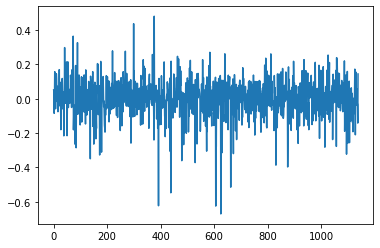

In [73]:
plt.plot(residuals)

In [74]:
# outliers removed
alpha_vector_2 = np.logspace(-9, 0, 10).tolist()
l1_ratio_vector_2 = np.linspace(0.001, 0.95, 10).tolist()
elasticnet_params = [{'alpha': alpha_vector_2, 'l1_ratio': l1_ratio_vector_2}]
elasticnet_2 = ElasticNet(normalize=True)
elasticnet_model_2 = GridSearchCV(elasticnet_2, elasticnet_params, cv = 5, scoring = "neg_mean_squared_error")
elasticnet_model_2.fit(X_train_no_outliers, y_train_no_outliers) 

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=True,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'alpha': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                                    0.001, 0.01, 0.1, 1.0],
                          'l1_ratio': [0.001, 0.10644444444444444,
                                       0.21188888888888888, 0.3173333333333333,
                                       0.42277777777777775, 0.5282222222222221,
                                       0.6336666666666666, 0.739111111111111,
                                       0.8445555555555555, 0.95]}],
             pre_dispatch='2*n_jobs

In [75]:
print("Best parameters:",elasticnet_model_2.best_params_)

Best parameters: {'alpha': 0.0001, 'l1_ratio': 0.8445555555555555}


In [76]:
y_train_predicted = elasticnet_model_2.predict(X_train_no_outliers)
RMSE_train = sqrt(mean_squared_error(y_train_no_outliers,y_train_predicted))
y_test_predicted = elasticnet_model_2.predict(X_test)
RMSE_test = sqrt(mean_squared_error(y_test,y_test_predicted))
print('RMSE for train data using ElasticNet is: %.5f' % RMSE_train)
print('RMSE for test data using ElasticNet is: %.5f' % RMSE_test)

RMSE for train data using ElasticNet is: 0.10481
RMSE for test data using ElasticNet is: 0.13828


In [77]:
Predicted_LogPrice_ElasticNet = elasticnet_model_2.predict(df_test_predictors)
Predicted_Price_ElasticNet = np.exp(Predicted_LogPrice_ElasticNet)
Final_Price_ElasticNet = pd.DataFrame(np.concatenate([df_test[['Id']],pd.DataFrame(Predicted_Price_ElasticNet)],axis=1))
Final_Price_ElasticNet.columns= ['Id','SalePrice']
Final_Price_ElasticNet['Id'] = Final_Price_ElasticNet['Id'].astype('int32')
Final_Price_ElasticNet
Final_Price_ElasticNet.to_csv("test_ElasticNet_price.csv",index = False)

# Step 5 - Build Gradient Boosting Model

### Label Encoding on Categorical Columns 

In [78]:
le = LabelEncoder()
df_categorical = df_combined.select_dtypes(include=[object]).drop('GarageYrBlt',axis =1) # 43 categorical columns
categorical_columns = list(df_categorical.columns)
df_categorical_le = df_categorical.apply(le.fit_transform)
df_categorical_le.head(5)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,3,1,1,3,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
1,3,1,1,3,3,0,2,0,24,1,...,1,2,5,5,2,3,4,1,8,4
2,3,1,1,0,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
3,3,1,1,0,3,0,0,0,6,2,...,5,3,5,5,2,3,4,1,8,0
4,3,1,1,0,3,0,2,0,15,2,...,1,2,5,5,2,3,4,1,8,4


### Combining Label Encoded Categorical Columns and Numeric Columns

In [79]:
df_numeric = df_combined._get_numeric_data() 
numeric_columns = list(df_numeric.columns)
df_le = pd.DataFrame(np.concatenate([df_numeric,df_categorical_le],axis = 1))
df_le.columns = numeric_columns + categorical_columns
df_le

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,5.0,3.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,0.0
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915.0,160.0,21.0,1936.0,4.0,7.0,1970.0,1970.0,0.0,0.0,...,6.0,1.0,3.0,3.0,2.0,3.0,4.0,1.0,8.0,4.0
2915,2916.0,160.0,21.0,1894.0,4.0,5.0,1970.0,1970.0,0.0,252.0,...,4.0,3.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,0.0
2916,2917.0,20.0,160.0,20000.0,5.0,7.0,1960.0,1996.0,0.0,1224.0,...,5.0,3.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,0.0
2917,2918.0,85.0,62.0,10441.0,5.0,5.0,1992.0,1992.0,0.0,337.0,...,6.0,1.0,3.0,3.0,2.0,3.0,2.0,3.0,8.0,4.0


### Split the test dataset from the train dataset  

In [80]:
X = df_le.iloc[:1460,:].drop(['Id','SalePrice','LogSalePrice'],axis =1)
Y = df_le.iloc[:1460,]['SalePrice']
X_Original_Test = df_le.iloc[1460:,].drop(['SalePrice','LogSalePrice'],axis =1) 

In [81]:
X.shape

(1460, 82)

### Initial GBM Model Fit

In [82]:
gbm = GradientBoostingRegressor()
gbm.set_params(verbose = 1)
gbm.fit(X,Y)
gbm.score(X,Y)

      Iter       Train Loss   Remaining Time 
         1  5414666697.2413            0.24s
         2  4670811099.6029            0.31s
         3  4064945702.8768            0.34s
         4  3559917680.1599            0.41s
         5  3127159220.5939            0.36s
         6  2766554720.6472            0.36s
         7  2464020257.2934            0.37s
         8  2206444029.1449            0.37s
         9  1981905228.2157            0.36s
        10  1784535935.3719            0.36s
        20   809356353.9819            0.31s
        30   510647600.5843            0.28s
        40   392797074.0168            0.25s
        50   327028738.4629            0.21s
        60   292320602.2855            0.17s
        70   267473609.2618            0.13s
        80   245723125.3323            0.09s
        90   233105582.0757            0.04s
       100   217394185.9758            0.00s


0.9655301294733736

### Train Test Split

In [83]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2,random_state = 42)

### Bagging 

In [84]:
gbm.set_params(learning_rate=0.03, n_estimators=800, verbose=1, subsample=0.7, warm_start=False, loss='ls', max_depth=4, max_features=2, min_impurity_decrease=0.01,random_state = 42)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.03, loss='ls', max_depth=4,
                          max_features=2, max_leaf_nodes=None,
                          min_impurity_decrease=0.01, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=800,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=0.7, tol=0.0001,
                          validation_fraction=0.1, verbose=1, warm_start=False)

In [85]:
gbm.fit(X_train,Y_train)
print('-'*50)
print("The train set R^2 is %.3f" %(gbm.score(X_train, Y_train)))
print("The test set R^2 is %.3f" %(gbm.score(X_test,Y_test)))
print("The difference between test and train is %.3f" %(gbm.score(X_train, Y_train)-gbm.score(X_test,Y_test)))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1  6239899733.6282   189658659.6929            1.60s
         2  5111332888.0278   140094527.3009            1.38s
         3  5676701913.3351   170003276.1288            1.18s
         4  5075219257.6807   121462807.0714            1.28s
         5  4991088058.6958   149680039.9634            1.18s
         6  5151590159.1290   129730646.4157            1.25s
         7  4844030871.3334   131100810.1966            1.29s
         8  4676630057.5156   124751570.6961            1.43s
         9  4720404395.2354   118879092.9074            1.36s
        10  4218205891.5667   121122143.5240            1.38s
        20  3354110972.8322    99498119.4699            1.11s
        30  2334621037.4883    52231976.3445            1.06s
        40  2140248366.2105    41738024.7627            1.17s
        50  1535943374.3546    22245469.6500            1.12s
        60  1253395542.1490    21140811.1962            1.07s
       

### Rank the Feature Importance and Select the top 35 features to refit GBM Model

In [86]:
sorted_importance = sorted(zip(X.columns.values, gbm.feature_importances_), key=lambda t:t[1], reverse=True)
sorted_importance_top35 = sorted_importance[:35]
sorted_importance_top35

[('HouseAge', 0.05986308093299578),
 ('GrLivArea', 0.053123032436120037),
 ('BsmtQual', 0.0437033945941471),
 ('GarageArea', 0.0428628332910568),
 ('OverallQual', 0.04275305176187684),
 ('ExterQual', 0.04001371999307796),
 ('FullBath', 0.03919810537939983),
 ('2ndFlrSF', 0.03660951023059982),
 ('Fireplaces', 0.03522326810300279),
 ('KitchenQual', 0.030517173107292506),
 ('TotalBsmtSF', 0.027672881124814586),
 ('AdjTotalBsmtSF', 0.02698926267124254),
 ('HeatingQC', 0.025748308043293554),
 ('BsmtFinSF1', 0.024527525891424484),
 ('AdjOutdoorSF', 0.024341445625522592),
 ('AdjTotalBath', 0.022566821462024166),
 ('YearBuilt', 0.02183314662821625),
 ('1stFlrSF', 0.021209430569942112),
 ('GarageType', 0.020730813370372865),
 ('BsmtExposure', 0.019636784393280177),
 ('LotArea', 0.019537057502091885),
 ('TotRmsAbvGrd', 0.018038011616791225),
 ('MasVnrArea', 0.017981592284771378),
 ('GarageFinish', 0.01736891673560805),
 ('GarageCars', 0.016382246105588985),
 ('Neighborhood', 0.014888563689822734

Text(0.5, 1.0, 'Feature Importance Plot of 500-Tree GBM')

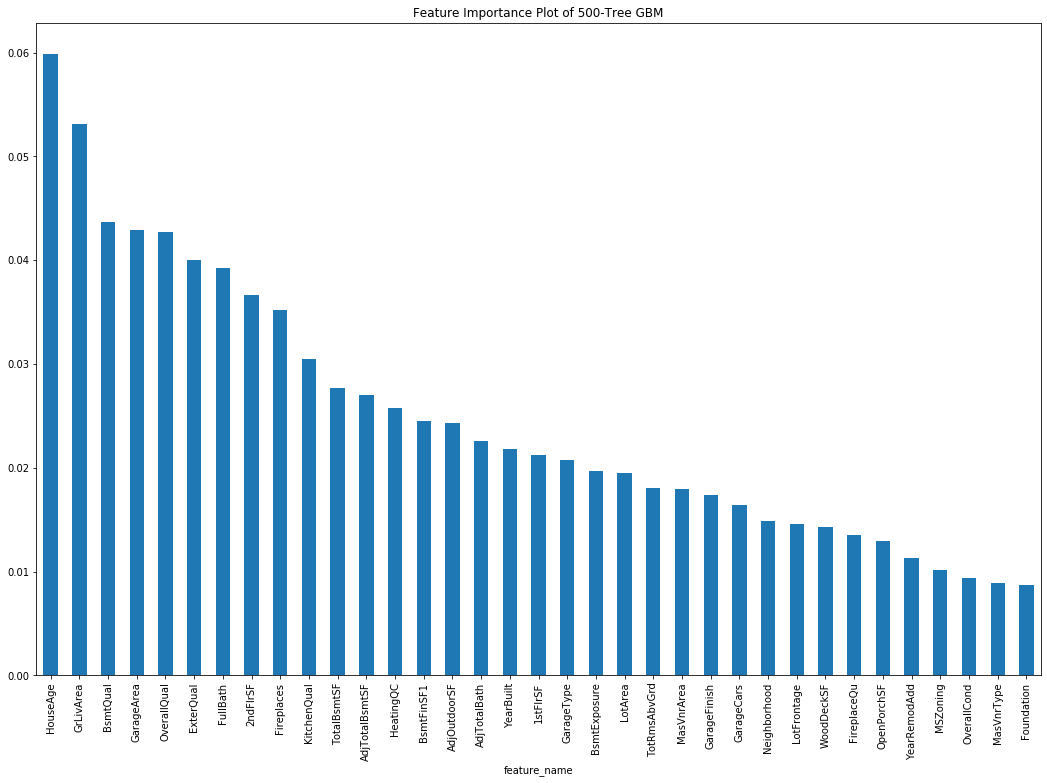

In [87]:
plt.rcParams['figure.figsize'] = (18,12)
a, b = zip(*sorted_importance_top35) # this splits the list of tuples into two lists
pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.bar(x='feature_name',y='importance_score', legend=None)
feature_selected = a
plt.title('Feature Importance Plot of 500-Tree GBM')

In [88]:
X_top35 = X.loc[:,list(feature_selected)] # Train Dataset
X_Original_Test_Predictor = X_Original_Test.loc[:,list(feature_selected)]
X_top35.head(5)

,HouseAge,GrLivArea,BsmtQual,GarageArea,OverallQual,ExterQual,FullBath,2ndFlrSF,Fireplaces,KitchenQual,...,Neighborhood,LotFrontage,WoodDeckSF,FireplaceQu,OpenPorchSF,YearRemodAdd,MSZoning,OverallCond,MasVnrType,Foundation
0,5.0,1710.0,2.0,548.0,7.0,2.0,2.0,854.0,0.0,2.0,...,5.0,65.0,0.0,3.0,61.0,2003.0,3.0,5.0,1.0,2.0
1,31.0,1262.0,2.0,460.0,6.0,3.0,2.0,0.0,1.0,3.0,...,24.0,80.0,298.0,5.0,0.0,1976.0,3.0,8.0,2.0,1.0
2,6.4,1786.0,2.0,608.0,7.0,2.0,2.0,866.0,1.0,2.0,...,5.0,68.0,0.0,5.0,42.0,2002.0,3.0,5.0,1.0,2.0
3,58.0,1717.0,4.0,642.0,7.0,3.0,1.0,756.0,1.0,2.0,...,6.0,60.0,0.0,2.0,35.0,1970.0,3.0,5.0,2.0,0.0
4,8.0,2198.0,2.0,836.0,8.0,2.0,2.0,1053.0,1.0,2.0,...,15.0,84.0,192.0,5.0,84.0,2000.0,3.0,5.0,1.0,2.0


In [89]:
X_top35_train, X_top35_test, Y_top35_train, Y_top35_test = train_test_split(X_top35,Y, test_size=0.2,random_state = 42)

In [90]:
gbm_top35 = GradientBoostingRegressor()
gbm_top35.set_params(learning_rate=0.03, n_estimators=900, verbose=1, subsample=0.7, warm_start=False, loss='ls', max_depth=4, max_features=2, min_impurity_decrease=0.01,random_state = 42)
# subsample = 0.7: each tree only use random 70% of the whole dataset for bagging

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.03, loss='ls', max_depth=4,
                          max_features=2, max_leaf_nodes=None,
                          min_impurity_decrease=0.01, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=900,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=0.7, tol=0.0001,
                          validation_fraction=0.1, verbose=1, warm_start=False)

In [91]:
gbm_top35.fit(X_top35_train,Y_top35_train)
print('-'*50)
print("The train set R^2 is %.3f" %(gbm_top35.score(X_top35_train, Y_top35_train)))
print("The test set R^2 is %.3f" %(gbm_top35.score(X_top35_test,Y_top35_test)))
a = gbm_top35.score(X_top35_train, Y_top35_train)
b = gbm_top35.score(X_top35_test,Y_top35_test)
print("Difference between train and test set R^2 is %.3f" % (a-b))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1  6247726367.8379   180808607.9897            0.91s
         2  5051668642.3950   207795156.8871            0.90s
         3  5562933517.6264   182623794.3848            0.89s
         4  4906762315.1391   198891698.0178            0.89s
         5  4783098351.9904   167540982.1750            0.99s
         6  4910303393.5195   151347408.7333            0.97s
         7  4584462122.2585   160860868.2296            0.96s
         8  4381381391.0880   149312049.1506            0.84s
         9  4393708917.1968   114953307.1110            0.74s
        10  3873151071.8057   157741833.0142            0.67s
        20  2806324532.7957    71461868.2699            0.69s
        30  1812210709.5940    57052434.9068            0.67s
        40  1666870532.0326    29562514.6414            0.58s
        50  1179746108.1741    18310061.1663            0.60s
        60   888336578.5751    22051101.5548            0.59s
       

### Using GridSerach to Tune Hyperparameters

In [92]:
grid_para_tree = [{
    'n_estimators':np.arange(500,1000,100),
    'learning_rate':np.linspace(0.02,0.05,10),
#     "min_samples_leaf": range(1, 10, 3),
#     'subsample': np.linspace(0.6,0.9,4),
    "min_samples_split": np.linspace(start=6, stop=16, num=7, dtype=int) # not recommend to do a through research, try num =7 first 
}]

gbm_top35.set_params(random_state=42)
grid_search_tree = GridSearchCV(gbm_top35, grid_para_tree, cv=3, n_jobs=6)
%time grid_search_tree.fit(X_top35_train, Y_top35_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1  6214216091.7554   199157238.7609            0.00s
         2  5005135943.9599   242237675.0714            4.54s
         3  5494538460.1003   200112907.3206            3.64s
         4  4789976436.3665   243842874.6772            2.73s
         5  4651120777.5112   199664439.7951            2.18s
         6  4739852911.8858   153011989.8939            1.81s
         7  4415489181.8236   172633958.1502            1.55s
         8  4182511974.6457   171961781.5633            2.25s
         9  4190947803.7962   121691194.8689            2.00s
        10  3667620127.2430   188397504.0994            1.80s
        20  2583304378.7283    71943736.7264            1.47s
        30  1627060238.1732    55664393.0946            1.47s
        40  1465147318.6565    30854116.4280            1.31s
        50  1033397761.7657    16482491.1738            1.24s
        60   790864152.8503    16325308.6963            1.14s
       

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.03,
                                                 loss='ls', max_depth=4,
                                                 max_features=2,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.01,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=900,
                                                 n_iter_...
                             

In [93]:
## best parameters
grid_search_tree.best_params_

{'learning_rate': 0.03333333333333333,
 'min_samples_split': 11,
 'n_estimators': 900}

In [94]:
print("Train set score is: %.3f" % grid_search_tree.score(X_top35_train, Y_top35_train))
print("Test set score is: %.3f" % grid_search_tree.score(X_top35_test, Y_top35_test))

Train set score is: 0.988
Test set score is: 0.920


### Use the best parameters and make a prediction on original test dataset

In [95]:
Predicted_test_price = grid_search_tree.predict(X_Original_Test_Predictor)
Final_Price_GBM = pd.DataFrame(np.concatenate([pd.DataFrame(X_Original_Test['Id']),pd.DataFrame(Predicted_test_price)],axis=1))
Final_Price_GBM.columns= ['Id','SalePrice']
Final_Price_GBM['Id'] = Final_Price_GBM['Id'].astype('int32')
Final_Price_GBM

,Id,SalePrice
0,1461,132127.027709
1,1462,161057.770814
2,1463,190688.933371
3,1464,202627.325208
4,1465,192296.019318
...,...,...
1454,2915,78589.327306
1455,2916,82905.314886
1456,2917,194068.129127
1457,2918,130182.084089


In [96]:
Final_Price_GBM.to_csv("test_price_GBM.csv", index = False)

### Stacking Linear Model and Tree Based Model

In [97]:
# ratios = np.linspace(0.1,0.9,9)
# for ratio in ratios:
#     Final_Price_Stacked = Final_Price_Lasso.copy()
#     Final_Price_Stacked['SalePrice'] = Final_Price_Lasso['SalePrice']*ratio+Final_Price_GBM['SalePrice']*(1-ratio)
#     Final_Price_Stacked.to_csv("test_price_stacked_"+str(ratio)+".csv", index = False)

# Step 6 - Stacking Lasso and GBM

In [98]:
ratio = 0.6
Final_Price_Stacked = Final_Price_Lasso.copy()
Final_Price_Stacked['SalePrice'] = Final_Price_Lasso['SalePrice']*ratio+Final_Price_GBM['SalePrice']*(1-ratio)
Final_Price_Stacked.to_csv("test_price_stacked_"+str(ratio)+".csv", index = False)

# Step 7- Stacking Lasso, Baysian Ridge and GBM

In [99]:
Final_Price_Stacked = Final_Price_Lasso.copy()
Final_Price_Stacked['SalePrice'] = Final_Price_Lasso['SalePrice']*0.2+ \
                                   Final_Price_BayesianRidge_gridSearch['SalePrice']*0.3 + \
                                   Final_Price_GBM['SalePrice']*0.5
Final_Price_Stacked

,Id,SalePrice
0,1461,121276.087825
1,1462,176879.865936
2,1463,183995.630032
3,1464,197369.838555
4,1465,187022.359403
...,...,...
1454,2915,83716.463808
1455,2916,86345.094429
1456,2917,180720.164502
1457,2918,125161.759221


In [100]:
Final_Price_Stacked.to_csv("test_price_stacked_3models.csv", index = False)

# Step 8 - K-means (unsupervised) clustering

### Use list of most important 35 features from tree models

In [101]:
# List of 35 features for k-means clustering
feature_list_for_k_means = []

for feature_tuple in sorted_importance_top35:
    feature_list_for_k_means.append(feature_tuple[0])

# We have sliced X by the 35 most important features as ranked by forests
X_for_k_means = X[feature_list_for_k_means]
print("Shape:",X_for_k_means.shape)
X_for_k_means.head(n = 5)

Shape: (1460, 35)


,HouseAge,GrLivArea,BsmtQual,GarageArea,OverallQual,ExterQual,FullBath,2ndFlrSF,Fireplaces,KitchenQual,...,Neighborhood,LotFrontage,WoodDeckSF,FireplaceQu,OpenPorchSF,YearRemodAdd,MSZoning,OverallCond,MasVnrType,Foundation
0,5.0,1710.0,2.0,548.0,7.0,2.0,2.0,854.0,0.0,2.0,...,5.0,65.0,0.0,3.0,61.0,2003.0,3.0,5.0,1.0,2.0
1,31.0,1262.0,2.0,460.0,6.0,3.0,2.0,0.0,1.0,3.0,...,24.0,80.0,298.0,5.0,0.0,1976.0,3.0,8.0,2.0,1.0
2,6.4,1786.0,2.0,608.0,7.0,2.0,2.0,866.0,1.0,2.0,...,5.0,68.0,0.0,5.0,42.0,2002.0,3.0,5.0,1.0,2.0
3,58.0,1717.0,4.0,642.0,7.0,3.0,1.0,756.0,1.0,2.0,...,6.0,60.0,0.0,2.0,35.0,1970.0,3.0,5.0,2.0,0.0
4,8.0,2198.0,2.0,836.0,8.0,2.0,2.0,1053.0,1.0,2.0,...,15.0,84.0,192.0,5.0,84.0,2000.0,3.0,5.0,1.0,2.0


### Use the elbow method to find the optimal number of clusters

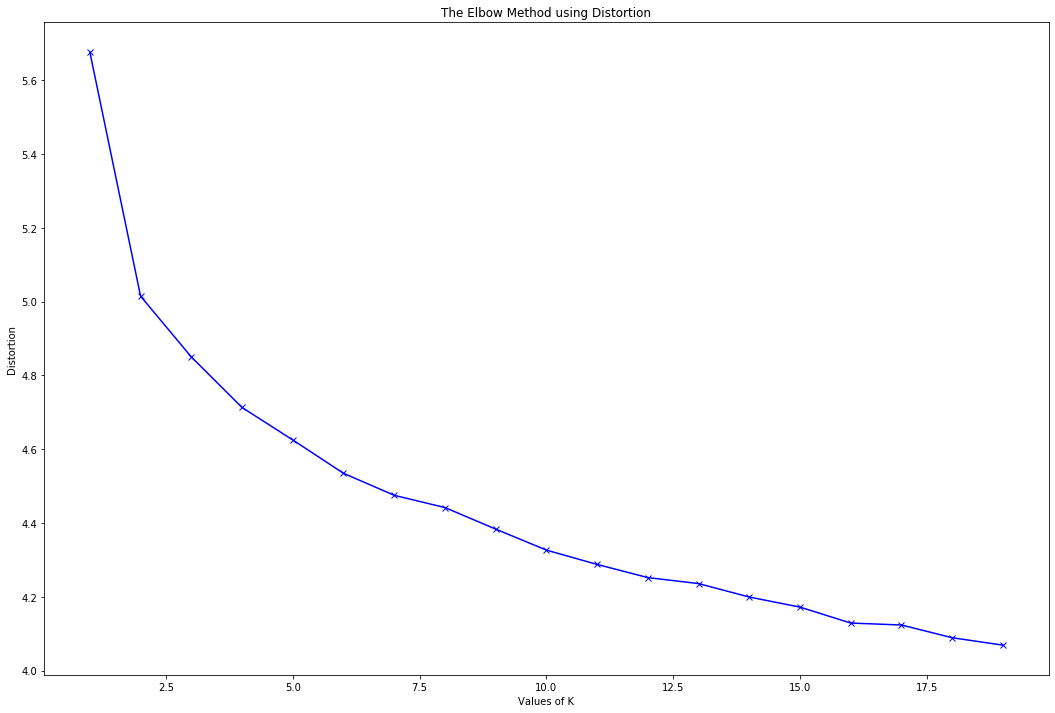

In [102]:
# Standardize the data to avoid issues where wider range features dominate in k-means
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_for_k_means)
X_for_k_means_scaled = scaler.transform(X_for_k_means)

# Now, use standardized features to run k-means, and then tell me the optimal number of clusters
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 

# Choosing the number of clusters using the elbow method
distortions = []
K_max = 20
K = range(1, K_max) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k) 
    kmeanModel.fit(X_for_k_means_scaled)     
      
    distortions.append(sum(np.min(cdist(X_for_k_means_scaled, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / X.shape[0]) 

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [103]:
### Looks like the optimal number is around 6 clusters

In [104]:
# Fit k-means with 6 clusters to each of the rows (houses), using standardized data
k_means_clustering = KMeans(n_clusters = 6, n_init = 10)
k_means_clustering.fit(X_for_k_means_scaled)

# Turn this into a pandas dataframe
X_labels = pd.DataFrame(k_means_clustering.labels_, columns = ["cluster"])
X_labels.head(n=5)

,cluster
0,5
1,2
2,5
3,1
4,5


In [105]:
# Add the cluster as a new feature, and also add the saleprice back to the dataframe
X_clustered = X_for_k_means.join(X_labels)
X_clustered = X_clustered.join(df_train["SalePrice"])
X_clustered.shape

(1460, 37)

In [106]:
# Print out details of the clusters
k_means_feature_list = ["SalePrice", "YearBuilt", "HouseAge", "GrLivArea", "1stFlrSF", "FullBath", "LotFrontage", "OverallQual", "KitchenQual"]
X_clustered.groupby("cluster")[k_means_feature_list].aggregate("median").sort_values("SalePrice", ascending = False)

,SalePrice,YearBuilt,HouseAge,GrLivArea,1stFlrSF,FullBath,LotFrontage,OverallQual,KitchenQual
cluster,,,,,,,,,
4,341000.0,2006.0,1.4,2020.0,1792.0,2.0,86.0,8.0,0.0
5,205000.0,2000.0,7.0,1786.0,927.0,2.0,70.0,7.0,2.0
0,203500.0,2004.0,4.0,1457.5,1442.0,2.0,70.0,7.0,2.0
2,180000.0,1965.0,36.0,1788.0,1390.0,2.0,80.0,6.0,3.0
3,138650.0,1965.0,35.0,1077.5,1053.0,1.0,72.0,5.0,3.0
1,113000.0,1932.0,56.4,1218.0,864.0,1.0,60.0,5.0,3.0
